In [1]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

import scipy.io as sio

from pynfft import NFFT
from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(img0)
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(img1)
    sub1.set_title(title1)
    
y = sio.loadmat("/home/jon/Desktop/export_mat/y.mat")['y'][0,0].reshape(307780)
p = np.asarray(sio.loadmat("/home/jon/Desktop/export_mat/p.mat")["p"])
dirty = np.asarray(sio.loadmat("/home/jon/Desktop/export_mat/dirty.mat")["dirty"])

p_shaped = np.reshape((0.5)*p, (p.shape[0]*p.shape[1]))
dim = (64,64)
plan = NFFT(dim, y.size)
plan.x = p_shaped
plan.precompute()

In [2]:
plan.f = y
dirty_map = np.real(plan.adjoint()).copy()
plan.f = np.ones(y.shape)
psf_map = np.real(plan.adjoint()).copy()
psf_map= psf_map / np.max(psf_map)

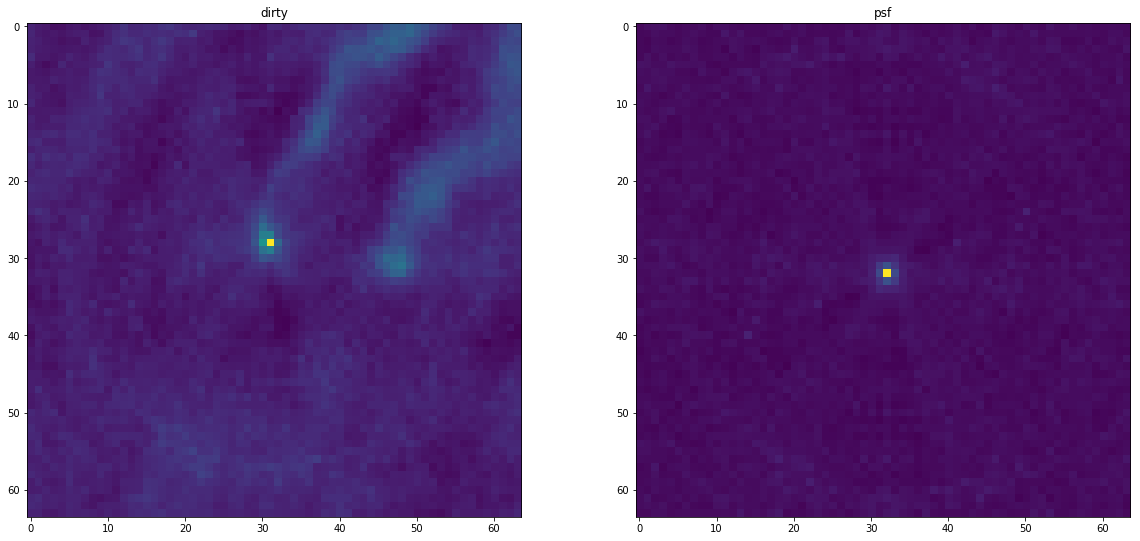

In [3]:
plot_comparison(dirty_map, 'dirty', psf_map, "psf")


In [4]:
def calcSpline():
    b3spline = np.asarray([1.0 / 16.0, 1.0 / 4.0, 3.0 / 8.0, 1.0 / 4.0, 1.0 / 16.0])

    row = np.asmatrix([b3spline])
    bla = (np.dot(np.transpose(row), row))
    return (np.dot(np.transpose(row), row))

def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0] * size[1], size[0] * size[1]))
    kernel = np.fliplr(np.flipud(kernel))

    disp = 2 ** J
    mid = kernel.shape[0] // 2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset + y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    # print(xi, yi)
                    mx = xi // size[0] % 2
                    xi = xi % size[0]
                    if mx == 1:
                        xi = size[0] - 1 - xi

                    my = yi // size[1] % 2
                    yi = yi % size[1]
                    if my == 1:
                        yi = size[1] - 1 - yi
                    # print(mx, my, xi, yi)
                    temp[xi, yi] += kernel[i, j]
    return (output)

In [5]:
model = Model("starlet regularizer")
model.Params.method = 0 #GRB Primal Simplex 

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 
print("psf filled to ", np.count_nonzero(psf)/(psf.size*1.0))
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)
    
XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

start_time = time.time()
starlet_levels=2
#starlet_levels = int(math.log(dirty_map.shape[0], 2))
star_c = []
star_w = []
star_w_abs = []
b3spline = calcSpline()
M_previous = 0
for J in range(0, starlet_levels):
    print("modelling starlet level "+ str(J+1) +" of "+ str(starlet_levels))
    
    star_cJ = []
    star_wJ = []
    star_wJ_abs = []
    for x in range(0, dirty_map.size):
        star_cJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ_abs.append(model.addVar())
    star_c.append(star_cJ)
    star_w.append(star_wJ)
    star_w_abs.append(star_wJ_abs)
    
    star_cminus = 0
    if J == 0:
        star_cminus = pixel_flat
        MJ = calcConvMatrix(dirty_map.shape, b3spline, J)
    else:
        star_cminus = star_c[J-1]
        tmp = calcConvMatrix(dirty_map.shape, b3spline, J)
        print(tmp.shape)
        print(M_previous.shape)
        start_time2= time.time()
        MJ = np.dot(M_previous,tmp)
        print(time.time() - start_time2)
    for x in range(0, dirty_map.size):
        reg = LinExpr()
        reg.addTerms(MJ[x], pixel_flat)
        model.addConstr(star_cJ[x] == reg)
        model.addConstr(star_wJ[x] ==  star_cminus[x] - star_cJ[x])
        model.addGenConstrAbs(star_wJ_abs[x], star_wJ[x])
    M_previous = MJ

print("modeling cJ")
star_c_abs= []
for x in range(0, dirty_map.size):
    star_c_abs.append(model.addVar())
    model.addGenConstrAbs(star_c_abs[x], star_c[J-1][x])
    
elapsed_time = time.time() - start_time
print("done starlet modelling ", elapsed_time)

Academic license - for non-commercial use only
Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
('psf filled to ', 0.096923828125)
1.0
('done psf modelling ', 9.000652074813843)
modelling starlet level 1 of 2
modelling starlet level 2 of 2
(4096, 4096)
(4096, 4096)
2.47172403336
modeling cJ
('done starlet modelling ', 25.825129985809326)


In [6]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.01 / starlet_levels
for J in range(0, starlet_levels):
    star_wJ_abs = star_w_abs[J]
    for x in range(0, dirty_map.size):
        objective += lamb * star_wJ_abs[x]
                                        
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet[x,y]= pixelArr[x][y].x

Optimize a model with 20480 rows, 36864 columns and 1785014 nonzeros
Model has 4096 quadratic objective terms
Model has 12288 general constraints
Variable types: 36864 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [5e-03, 5e-03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+05]
Presolve removed 12288 rows and 12288 columns (presolve time = 5s) ...
Presolve added 8192 rows and 0 columns
Presolve removed 0 rows and 12288 columns
Presolve time: 5.51s
Presolved: 28672 rows, 24576 columns, 1783110 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 24576 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      6s
       0    2.4261495e+12   0.000000e+00   2.168546e+08      6s
    4824    1.4869732e+12   0.000000e+00   3.100993e+09  

   94817    9.9603678e+11   0.000000e+00   5.991315e+08    560s
   95427    9.9360902e+11   0.000000e+00   4.343363e+10    565s
   96037    9.8154526e+11   0.000000e+00   2.442728e+10    570s
   96647    9.7944586e+11   0.000000e+00   1.271447e+11    575s
   97257    9.7915918e+11   0.000000e+00   1.604591e+11    580s
   97867    9.7775424e+11   0.000000e+00   1.322790e+11    586s
   98477    9.7707397e+11   0.000000e+00   2.403312e+11    591s
   99087    9.7536594e+11   0.000000e+00   3.938300e+11    596s
   99697    9.7427628e+11   0.000000e+00   5.356371e+11    601s
  100307    9.7351551e+11   0.000000e+00   3.991958e+11    605s
  101039    9.7110886e+11   0.000000e+00   6.799572e+10    610s
  101771    9.7104595e+11   0.000000e+00   6.074802e+11    616s
  102381    9.6854853e+11   0.000000e+00   7.774285e+11    620s
  103113    9.6789366e+11   0.000000e+00   1.964587e+12    625s
  103845    9.6734718e+11   0.000000e+00   2.338350e+12    631s
  104577    9.6734380e+11   0.000000e+00

  162619    9.6347217e+11   0.000000e+00   8.003964e+10   1201s
  163093    9.6347217e+11   0.000000e+00   2.041925e+11   1205s
  163725    9.6347217e+11   0.000000e+00   3.577738e+11   1210s
  164357    9.6347217e+11   0.000000e+00   7.105321e+12   1215s
  164989    9.6347217e+11   0.000000e+00   1.141964e+13   1221s
  165463    9.6346260e+11   0.000000e+00   1.980088e+11   1225s
  166095    9.6346076e+11   0.000000e+00   3.260485e+12   1231s
  166727    9.6344531e+11   0.000000e+00   7.526524e+11   1236s
  167359    9.6336569e+11   0.000000e+00   6.335308e+07   1240s
  167991    9.6329291e+11   0.000000e+00   6.616614e+08   1245s
  168781    9.6328189e+11   0.000000e+00   3.692581e+08   1251s
  169413    9.6328188e+11   0.000000e+00   1.705783e+08   1256s
  170045    9.6328187e+11   0.000000e+00   3.286182e+10   1261s
  170677    9.6328187e+11   0.000000e+00   2.280975e+08   1266s
  171309    9.6328187e+11   0.000000e+00   7.087699e+08   1270s
  172099    9.6328187e+11   0.000000e+00

  226746    9.6327430e+11   0.000000e+00   9.476592e+08   1840s
  227256    9.6327430e+11   0.000000e+00   2.967207e+08   1845s
  227766    9.6327430e+11   0.000000e+00   2.336198e+09   1850s
  228276    9.6327430e+11   0.000000e+00   1.070209e+09   1855s
  228786    9.6327430e+11   0.000000e+00   1.259388e+08   1860s
  229296    9.6327430e+11   0.000000e+00   1.599555e+08   1865s
  229806    9.6327430e+11   0.000000e+00   6.750094e+08   1871s
  230316    9.6327430e+11   0.000000e+00   3.746839e+08   1876s
  230724    9.6327430e+11   0.000000e+00   1.195884e+08   1881s
  231234    9.6327430e+11   0.000000e+00   8.044842e+08   1886s
  231744    9.6327430e+11   0.000000e+00   1.534535e+08   1891s
  232254    9.6327430e+11   0.000000e+00   1.168881e+08   1896s
  232662    9.6327430e+11   0.000000e+00   2.391046e+09   1900s
  233172    9.6327430e+11   0.000000e+00   5.373689e+08   1905s
  233682    9.6327430e+11   0.000000e+00   2.718985e+08   1911s
  234090    9.6327430e+11   0.000000e+00

  280847    9.6079829e+11   0.000000e+00   2.188260e+09   2485s
  281255    9.6079829e+11   0.000000e+00   2.359802e+11   2491s
  281561    9.6079821e+11   0.000000e+00   8.431018e+09   2496s
  281867    9.6079821e+11   0.000000e+00   5.070143e+09   2500s
  282275    9.6079821e+11   0.000000e+00   4.977204e+09   2506s
  282581    9.6079821e+11   0.000000e+00   1.335356e+11   2510s
  283091    9.6059970e+11   0.000000e+00   5.231853e+12   2516s
  283499    9.6059953e+11   0.000000e+00   9.214978e+11   2521s
  283907    9.6059948e+11   0.000000e+00   2.162723e+13   2526s
  284247    9.6140405e+11   0.000000e+00   8.471748e+09   2531s
  284655    9.6140176e+11   0.000000e+00   3.777993e+10   2536s
  285165    9.6134713e+11   0.000000e+00   9.911512e+09   2541s
  285675    9.6123847e+11   0.000000e+00   1.944424e+08   2546s
  286185    9.6115802e+11   0.000000e+00   1.128058e+08   2550s
  286796    9.6115802e+11   0.000000e+00   5.303096e+10   2556s
  287306    9.6115802e+11   0.000000e+00

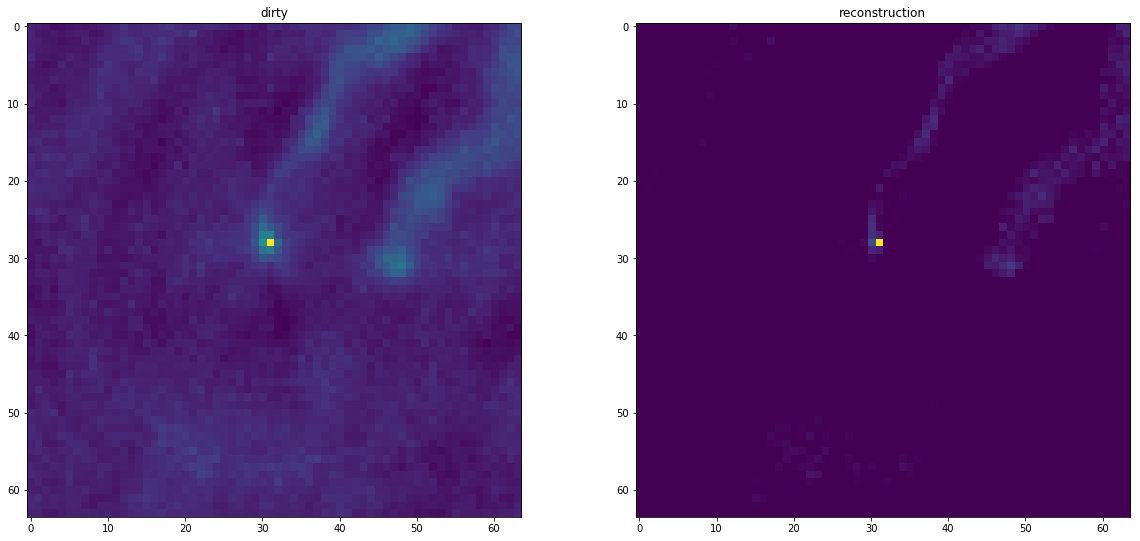

In [7]:
plot_comparison(dirty_map, 'dirty', results_starlet, "reconstruction")

In [44]:
psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 
print("psf filled to ", np.count_nonzero(psf)/(psf.size*1.0))

('psf filled to ', 0.04779052734375, '%')


In [15]:
psf = psf_map.copy()

In [16]:
np.count_nonzero(psf)

16384

In [19]:
psf[np.absolute(psf) < 0.001] = 0 

In [24]:
np.count_nonzero(psf)

15141

In [25]:
np.count_nonzero(psf)/(psf.size*100.0)

0.0092413330078125

In [22]:
psf.size*100.0

1638400.0

361436.5130657926